# Sections

[Objective](#Objective)  
[Setup](#Setup)  
[Load data](#Load-data)  
[Price](#Price)  
[Size](#Size)  
[Location](#Location)  
[Features](#Features)  
[Scratchpad](#Scratchpad)

# Objective
[Back to top](#Sections)

#### Predict the price of a New York City apartment.

This project uses data from this Kaggle <a href='https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data'>competition</a>. The data comes from renthop.com, an apartment listing website. See ```data_import.ipynb``` for a detailed description.

## Setup
[Back to top](#Sections)

In [2]:
from __future__ import print_function, division

In [3]:
from collections import OrderedDict
from collections import Counter
import numpy as np
import pandas as pd
import re
import seaborn as sns
import sys
import matplotlib.pyplot as plt
%matplotlib inline

Import functions for producing nicely formatted output.

In [ ]:
# %load utils.py
from IPython.display import display, HTML

def pp_bold(str):
    display(HTML('<b>{}</b>'.format(str)))


def pp_listOflist(l):
    display(HTML(
        u'<table>{}</table>'.format(
            u''.join(u'<tr>{}</tr>'.format(
                u''.join(u'<td>{}</td>'.format(v) for v in sublist)) for sublist in l))))
    

def pp_dict(d, rows=None):
    if not rows or rows >= len(d):
        display(HTML(
            u'<table>{}</table>'.format(
                u''.join(u'<tr><td><b>{}</b></td><td>{}</td></tr>'.format(k, d[k]) for k in d))))
    else:
        nitems = len(d)
        width = -(-nitems // rows)
        i = 0
        list_ = [[] for _ in range(rows)]
        for _ in range(width):
            for row in range(rows):
                if i < nitems:
                    k, v = d.items()[i]
                    list_[row].extend(['<b>{}</b>'.format(k), v])
                i += 1
        pp_listOflist(list_)


def pp_dictOflist(d):
    display(HTML(
        u'<table>{}</table>'.format(
            u''.join(u'<tr><td><b>{}</b></td>{}</tr>'.format(k,
                u''.join(u'<td>{}</td>'.format(v) for v in d[k])) for k in d.keys()))))
    

def pp_dfinfo(df, width=4):
    ncols = len(df.columns)
    width = min(width, ncols)
    depth = -(-ncols // width)
    i = 0
    list_ = [[] for _ in range(depth)]
    for _ in range(width):
        for row in range(depth):
            if i < ncols:
                col = df.columns[i]
                list_[row].extend(['<b>{}</b>'.format(col), df[col].count(), df.dtypes[i]])
            i += 1

    print('{} entries, {} columns'.format(len(df), ncols))
    pp_listOflist(list_)


def pp_counts(series, rows=1, caption=None):
    if caption: pp_bold(caption)
    list_ = [(k, '{:.4f}'.format(v)) for k, v in series.to_dict().items()] 
    dict_ = OrderedDict(sorted(list_, key=lambda x: x[0]))
    pp_dict(dict_, rows)


def pp_progress(s):
    sys.stdout.write('\r{}'.format(s))
    sys.stdout.flush()


Define functions for creating plots and summary tables.

In [14]:
# %load plots.py
def percentplot(data, var, title=None, xlabel='', ax=None):
    ax = sns.barplot(x=var, y=var, data=data, estimator=lambda x: len(x) * 100 / len(data))
    ax.set(ylabel="Percent")
    ax.set(xlabel=xlabel if xlabel else '')
    ax.set(title=var if not title else title)
    return ax

    
def feature_hist(df, column, title=None, xlabel='', rotation=None):
    fig = plt.figure(figsize=(10, 4))
    ax1 = percentplot(df, column, title, xlabel=xlabel, ax=plt.subplot(111))
    if rotation:
        for item in ax1.get_xticklabels():
            item.set_rotation(rotation)

## Load data
[Back to top](#Sections)

Open listings database

In [6]:
from pymongo import MongoClient

In [7]:
client = MongoClient('ec2-34-198-246-43.compute-1.amazonaws.com', 27017)
db = client.renthop
collection = db.listings
pp_bold('{} listings'.format(collection.count()))

Print one of them.

In [8]:
pp_dict(collection.find_one())

loc,"{u'type': u'Point', u'coordinates': [-73.9389, 40.7245]}"
listing_id,6818139
_id,58ac97520b0203c6b6436f4c
display_address,Hausman Street
description,"This one WON'T LAST!! Here is a stunning 3 Bedroom, 2 Full Bathroom apartment measuring approximately 1100 sqft! The layout is NOT a railroad with a King Sized master bedroom complete with on suite full bathroom and bay-windows. The 2nd and 3rd bedrooms can fit a Full or Queen sized bed and have over-sized windows. Thee is a second full bathroom with soaking tub off of the main hallway. Open concept kitchen with large island finished in real stone counters and soft close cabinetry plus Stainless Steel industrial sized appliances! Heated hardwood flooring throughout with tons of sunlight and space. Central HVAC means that you never have to be too hot or too cold again!One of the best locations for street parking in Greenpoint! Don't have a car? No Problem, the Nassau G Train and Grand St L train are within reach.Call, Text, Email Taylor now to schedule your private showing. Not exactly what you are looking for? Email me your search criteria, I Specialize in North Brooklyn!-------------Listing courtesy of Miron Properties. All material herein is intended for information purposes only and has been compiled from sources deemed reliable. Though information is believed to be correct, it is presented subject to errors, omissions, changes or withdrawal without notice. Miron Properties is a licensed Real Estate Broker. www.MironProperties.com<a website_redacted"
created,2016-04-03 02:22:45
price,2995
bedrooms,3
interest_level,medium
longitude,-73.9389
photos,https://photos.renthop.com/2/6818139_a50e80ff79c71a1ced4ec103985abdd9.jpg https://photos.renthop.com/2/6818139_a2be68c008aeff88347f97dc0350f85d.jpg https://photos.renthop.com/2/6818139_63166d3d69203d7bd63e8e8bb47db8c6.jpg https://photos.renthop.com/2/6818139_1aba230faec5ed91372bb3996b98acf1.jpg https://photos.renthop.com/2/6818139_af28eb103bab59ec9d929c3657d846e6.jpg https://photos.renthop.com/2/6818139_3637c3737c1286332310476fa4d5b1d8.jpg https://photos.renthop.com/2/6818139_83f4bfb1928581fb9feec154629f62e9.jpg


Copy listing, sans metadata, to dataframe.

In [9]:
%%time
c = collection.find({}, {'_id':0, 'id':0, 'building_id':0, 'manager_id':0, 'listing_id':0, 'photos':0})
df = pd.DataFrame(list(c))
df.interest_level = df.interest_level.astype('category', categories=['low', 'medium', 'high'])

CPU times: user 0 ns, sys: 2.47 s, total: 2.47 s
Wall time: 8.7 s


## Price
[Back to top](#Sections)

The highest price is 4.5 million and there are six listings above so $100,000. I think those are all mistakes because they're for studio, one- and two-bedroom apartments. Drop them.

In [10]:
df[df.price>1e5][['bedrooms', 'bathrooms', 'price', 'interest_level']]

,bedrooms,bathrooms,price,interest_level
11191,2,1.0,4490000,low
12283,0,1.0,111111,high
13494,2,1.0,1150000,low
26830,0,0.0,135000,low
35191,1,1.0,1070000,low
35711,1,1.0,1070000,low


In [11]:
df = df.drop(df[df.price>1e5].index)

Bin prices in increments of 500 up to 10,000, then one bin for everything above that. The range 0 to 10,000 captures >98% of the listings.

In [38]:
price_bins = range(0, 10001, 500) + [1e5]
bins = pd.cut(df.price, bins=price_bins)
df['price_bucket'] = bins.apply(lambda x: re.sub('\([0-9]+, ([0-9]+)\]', '\\1', x)).astype(int)

500,0.0001,2000,0.0934,3500,0.1601,5000,0.0545,6500,0.0198,8000,0.0071,9500,0.0020
1000,0.0004,2500,0.1647,4000,0.1123,5500,0.0341,7000,0.0116,8500,0.0035,10000,0.0031
1500,0.0137,3000,0.1970,4500,0.0637,6000,0.0299,7500,0.0080,9000,0.0034,100000,0.0177


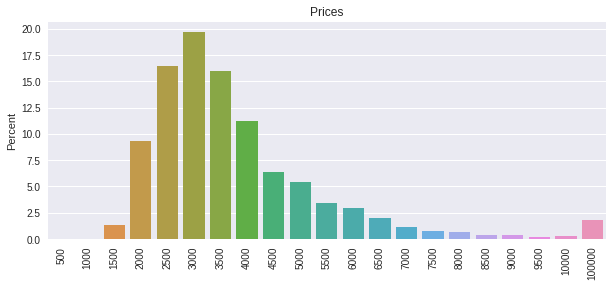

In [39]:
feature_hist(df, 'price_bucket', title='Prices', rotation=90)
pp_counts(df.price_bucket.value_counts(normalize=True), rows=3, caption='Price distribution:')

## Size
[Back to top](#Sections)

### Bedrooms

Eighty-percent of listings are for studios and one- and two-bedrooms apartments.

0,0.1920,1,0.3192,2,0.2963,3,0.1474,4,0.0391,5,0.0050,6,0.0009,7,0.0000,8,0.0000


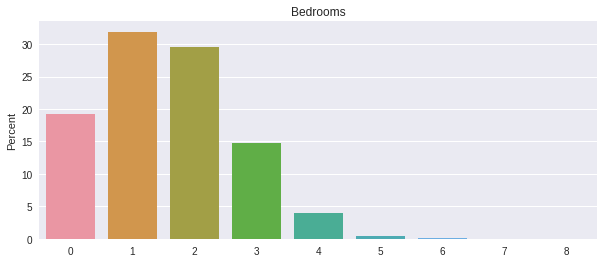

In [40]:
feature_hist(df, 'bedrooms', 'Bedrooms')
pp_counts(df.bedrooms.value_counts(normalize=True), caption='Bedrooms distribution:')

### Bathrooms

For completeness sake, look at the number of bathrooms.

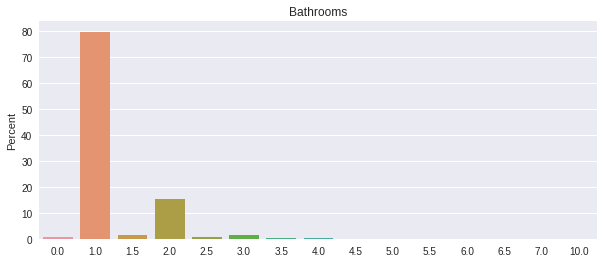

In [41]:
feature_hist(df, 'bathrooms', 'Bathrooms')
pp_counts(df.bathrooms.value_counts(normalize=True), rows=2, caption='Bathrooms distribution:')

## Location
[Back to top](#Sections)

The cliche is that real estate is all about location, location, location. I'll use GeoPandas to map listings.

In [42]:
import geopandas as gpd
from shapely.geometry import Point

Ignore listings outside New York to make the mapping easier. There are only a few of them.

In [43]:
geo_df = df.copy()
outside_nyc = geo_df[(geo_df.longitude < -74.2) | (geo_df.longitude > -73.7) | (geo_df.latitude < 40.5) | (geo_df.latitude > 40.9)]
geo_df = geo_df.drop(outside_nyc.index)
pp_bold('Ignoring {} listings, {} remain'.format(len(outside_nyc), len(geo_df)))

What's the relationship between location and price?

In [44]:
from mpl_toolkits.mplot3d import Axes3D

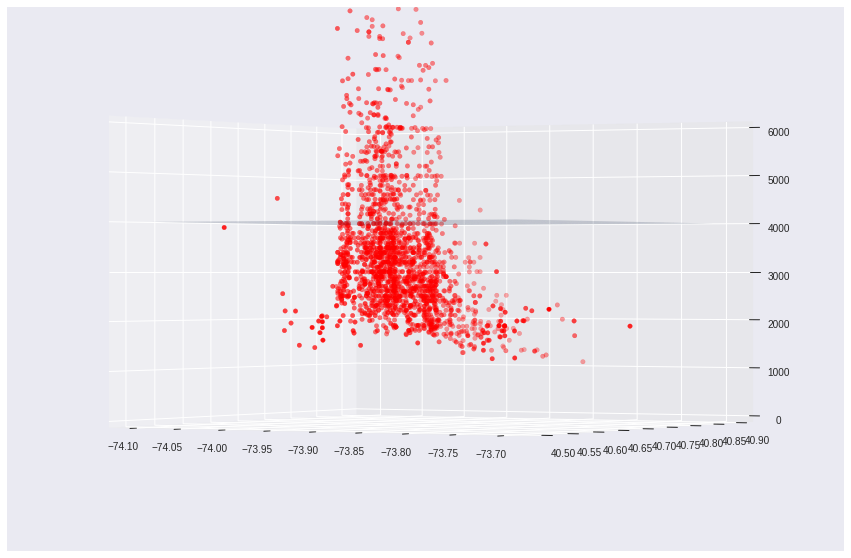

In [48]:
def price3dplot(df, ax, color, zplane=4000, zlimit=(0, 6000)):
    ax.view_init(elev=0)
    ax.set_zlim(*zlimit)
    ax.scatter(df.longitude, df.latitude, df.price, c=[color]*len(df))
    xx, yy = np.meshgrid(np.linspace(-74.1, -73.7, 20), np.linspace(40.5, 40.9, 20))
    ax.plot_surface(xx, yy, [zplane]*len(xx), alpha=0.2)
    return ax

df_sample = geo_df.sample(2000)
fig = plt.figure(figsize=(15, 10))
price3dplot(df_sample, fig.add_subplot(111, projection='3d'), 'r')
plt.show()

## Features
[Back to top](#Sections)

The "features" field is a non-standardized list of attributes of the apartment/building. The same attribute appears in different forms. For example, the following terms are all used to describe that the apartment has a washer and dryer: 

- "laundry in unit"
- "washer in unit"
- "dryer in unit"
- "washer/dryer"
- "washer & dryer"
- "in unit washer/dryer"
- "washer/dryer in unit"

To clean this up, first map all aliases to a single canonical term. The mapping comes from a JSON file I created that lists the recognized aliases for each term. For example:

```python
{ "bike-room" : [
    "bike storage"
]},
{ "central air" : [
    "central a/c", "central ac"
]},
{"common outdoor space" : [
    "roof deck", "publicoutdoor", 
    "common terrace", "roofdeck", "building common outdoor space",
    "residents garden", "outdoor areas", "common roof deck",
    "courtyard", "common garden", "rooftop deck", "common backyard",
    "rooftop terrace", "deck", "shared backyard"
]},
```

The file also collapses some related terms into a single concept, e.g., ```common outdoor space```.

In [49]:
import json

In [51]:
# Load JSON file into dictionary mapping synonyms to canonical terms
with open('app/synonyms.json') as fd:
    synomyns = json.load(fd)
canon = {alias : term for s in synomyns for term, aliases in s.items() for alias in aliases}

def unalias(name):
    """
    Look up the canonical version of a string. Returns the
    original string when none is found.
    """
    return canon.get(name, name)

Now we can count the features. There are over eleven hundred! But, most of these are junk and only appear a handful of times.

In [52]:
all_features = Counter()
for l in df.features:
    unit_features = l.lower().replace('-', ' ').split('\n')
    all_features.update([unalias(f) for f in unit_features if f])
pp_bold('{} unique features'.format(len(all_features)))

Let's examine the top 50 terms. Observe the prevalence drops off  dramtically.

In [54]:
pp_dict(OrderedDict(all_features.most_common(50)), rows=15)

## Scratchpad
[Back to top](#Sections)